# Energy Prediction Workshop

Welcome! In this short workshop, we'll walk through the basic steps of building a model to predict energy consumption.

**Our Goals Today:**
1.  Load historical energy data (using AEP hourly consumption data) **from a local file**.
2.  Explore and visualize the consumption (load) data.
3.  Prepare the data for modeling.
4.  Build a simple prediction model for total load.
5.  Evaluate the model's performance.

**Python Packages Used:**
* pandas
* numpy
* matplotlib
* scikit-learn
* os (standard library)

## Exercise 1: Setup and Data Loading (Local File - NO Error Handling)

First, import the necessary Python libraries.

**🛑 VERY IMPORTANT PREREQUISITE 🛑**

This notebook **requires** the data file named `AEP_hourly.csv` to be present in the **exact same directory** as this notebook file (`.ipynb`). 

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os

# --- Configuration ---
local_file_name = 'AEP_hourly.csv' # <-- NEW FILENAME
datetime_column = 'Datetime'       # <-- Column with date/time info
target_column = 'AEP_MW'           # <-- Column we want to predict

# --- Load Data (Directly - Will Crash on Any Error) ---
print(f"Attempting to load '{local_file_name}' from directory: {os.getcwd()}")
print("⚠️ Reminder: No error handling is active for this step.")

# Load CSV, parse 'Datetime' column as dates, and set it as index
# This line will crash if file not found, cannot be read, 'Datetime' column missing/unparseable
df = pd.read_csv(local_file_name,
                 parse_dates=[datetime_column],
                 index_col=datetime_column)

# The AEP dataset from common sources is usually timezone-naive.
# If it happened to be timezone-aware, this would convert it:
# if isinstance(df.index, pd.DatetimeIndex) and df.index.tz is not None:
#     print(f"Original timezone detected: {df.index.tz}. Converting to naive UTC representation...")
#     df.index = df.index.tz_convert(None)
# else:
#     print("Index is already timezone-naive or not a DatetimeIndex (problem!).")


print(f"\nSuccessfully loaded '{local_file_name}'.")
print(f"Index type is: {type(df.index)}, Index dtype: {df.index.dtype}") # Verify

# --- Basic Check & Display (Assumes df exists and has target_column) ---
# These lines will crash if df wasn't created or target_column is missing
print(f"Target column: '{target_column}'")
print(f"Data time range: {df.index.min()} to {df.index.max()}")
print("\nFirst 5 rows (target column):")
print(df[[target_column]].head())

# Subsequent cells assume 'df' was successfully created with a DatetimeIndex.

Attempting to load 'AEP_hourly.csv' from directory: /Users/jamie-temp/git/energy-prediction
⚠️ Reminder: No error handling is active for this step.

Successfully loaded 'AEP_hourly.csv'.
Index type is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>, Index dtype: datetime64[ns]
Target column: 'AEP_MW'
Data time range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00

First 5 rows (target column):
                      AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0


## Exercise 2: Data Exploration and Preprocessing

Now we'll explore the **AEP_MW** column from our loaded data (`df`), which represents hourly energy consumption in Megawatts.
* We'll create a new DataFrame (`df_load`) containing only this target column.
* We'll check for and handle any missing values.
* We'll visualize the load over time.

Creating df_load focusing on 'AEP_MW'...

Checking for missing values in 'AEP_MW'...
Initial missing values: 0
Filling missing values (if any) using forward fill then backward fill...
Missing values after fill: 0

Plotting AEP Hourly Energy Consumption...


/var/folders/x7/_6f3966s4qsb2d1tdmfnf08c0000gp/T/ipykernel_9598/4195638913.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_load.fillna(method='ffill', inplace=True)
/var/folders/x7/_6f3966s4qsb2d1tdmfnf08c0000gp/T/ipykernel_9598/4195638913.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_load.fillna(method='bfill', inplace=True)


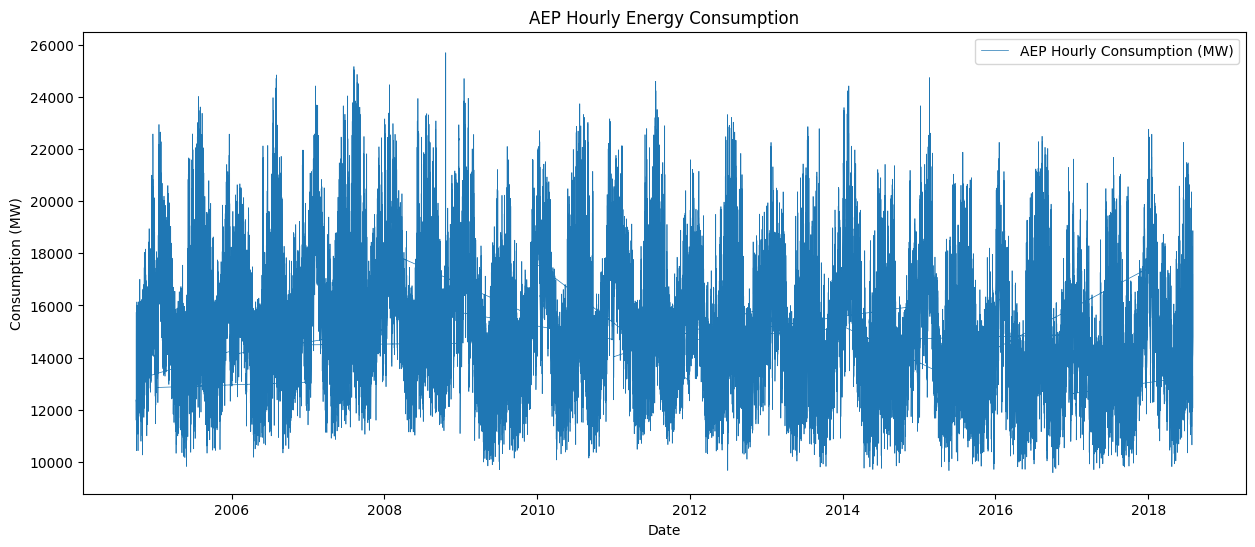


Summary Statistics for 'AEP_MW':
count    121273.000000
mean      15499.513717
std        2591.399065
min        9581.000000
25%       13630.000000
50%       15310.000000
75%       17200.000000
max       25695.000000
Name: AEP_MW, dtype: float64


In [13]:
# --- Create a DataFrame focused on the target column ---
# Assumes 'df' exists and 'target_column' (AEP_MW) is defined and present.
print(f"Creating df_load focusing on '{target_column}'...")
df_load = df[[target_column]].copy()

# --- Handle missing values in the target column ---
print(f"\nChecking for missing values in '{target_column}'...")
missing_count = df_load[target_column].isnull().sum()
print(f"Initial missing values: {missing_count}")

print("Filling missing values (if any) using forward fill then backward fill...")
df_load.fillna(method='ffill', inplace=True)
df_load.fillna(method='bfill', inplace=True)
print(f"Missing values after fill: {df_load[target_column].isnull().sum()}")


# --- Plot the time series ---
print("\nPlotting AEP Hourly Energy Consumption...")
plt.figure(figsize=(15, 6))
plt.plot(df_load.index, df_load[target_column], label='AEP Hourly Consumption (MW)', linewidth=0.5)
plt.title('AEP Hourly Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.show()

# --- Display summary statistics ---
print(f"\nSummary Statistics for '{target_column}':")
print(df_load[target_column].describe())

## Exercise 3: Feature Engineering

Machine learning models need features (inputs) to make predictions. From `df_load`, we'll use its `DatetimeIndex` (derived from the 'Datetime' column) to create:
* Hour of the day
* Day of the week
* Quarter of the year
* Month
* Year
* Day of the year

In [16]:
# --- Create time-based features ---
# Assumes df_load exists and its index is a DatetimeIndex.
print("Creating time-based features from the DatetimeIndex of df_load...")

df_load['hour'] = df_load.index.hour
df_load['dayofweek'] = df_load.index.dayofweek
df_load['quarter'] = df_load.index.quarter
df_load['month'] = df_load.index.month
df_load['year'] = df_load.index.year
df_load['dayofyear'] = df_load.index.dayofyear

print("DataFrame (`df_load`) with new time features added:")
print(df_load.head())

Creating time-based features from the DatetimeIndex of df_load...
DataFrame (`df_load`) with new time features added:
                      AEP_MW  hour  dayofweek  quarter  month  year  dayofyear
Datetime                                                                      
2004-12-31 01:00:00  13478.0     1          4        4     12  2004        366
2004-12-31 02:00:00  12865.0     2          4        4     12  2004        366
2004-12-31 03:00:00  12577.0     3          4        4     12  2004        366
2004-12-31 04:00:00  12517.0     4          4        4     12  2004        366
2004-12-31 05:00:00  12670.0     5          4        4     12  2004        366


## Exercise 4: Building a Simple Prediction Model

Now, let's build a basic **Linear Regression** model.
**Steps:**
1.  **Define Features (X) and Target (y):** Use the time-based features as input (X) and 'AEP_MW' as the target (y).
2.  **Split Data:** Divide into training and testing sets (last year for testing).
3.  **Train Model:** Fit the Linear Regression model to the training data.
4.  **Make Predictions:** Predict consumption for the test set.

In [17]:
# --- Define Features and Target ---
# Assumes df_load exists and contains the features and 'target_column' (AEP_MW).
print("Preparing data for modeling...")
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
# target_column is already defined as 'AEP_MW' in Cell 1

X = df_load[FEATURES]
y = df_load[target_column]

# --- Split data into Training and Testing sets ---
split_date = df_load.index.max() - pd.DateOffset(years=1)
print(f"Splitting data at: {split_date}")

X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

# --- Initialize and Train the Linear Regression model ---
print("\nInitializing and training the Linear Regression model...")
model = LinearRegression()
model.fit(X_train, y_train)
print("Model training complete.")

# --- Make Predictions on the Test Set ---
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)
print("Predictions made.")

# --- Store results for comparison ---
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
print("\nSample of Actual vs. Predicted values:")
print(results_df.head())

Preparing data for modeling...
Splitting data at: 2017-08-03 00:00:00
Training data shape: X=(112512, 6), y=(112512,)
Testing data shape: X=(8761, 6), y=(8761,)

Initializing and training the Linear Regression model...
Model training complete.

Making predictions on the test set...
Predictions made.

Sample of Actual vs. Predicted values:
                      Actual     Predicted
Datetime                                  
2017-12-31 01:00:00  17422.0  11786.463363
2017-12-31 02:00:00  17219.0  11944.425159
2017-12-31 03:00:00  17313.0  12102.386955
2017-12-31 04:00:00  17396.0  12260.348751
2017-12-31 05:00:00  17512.0  12418.310547


## Exercise 5: Evaluating the Model

How well did our simple model do? We'll use the **Mean Absolute Error (MAE)**. We'll also plot the actual vs. predicted values for the AEP consumption data.

Calculating model performance metrics...

Mean Absolute Error (MAE) on Test Set: 1661.51 MW
Average Consumption in Test Set: 14963.11 MW
MAE as percentage of Average Consumption: 11.10%

Plotting Actual vs. Predicted values for the Test Set (first month)...


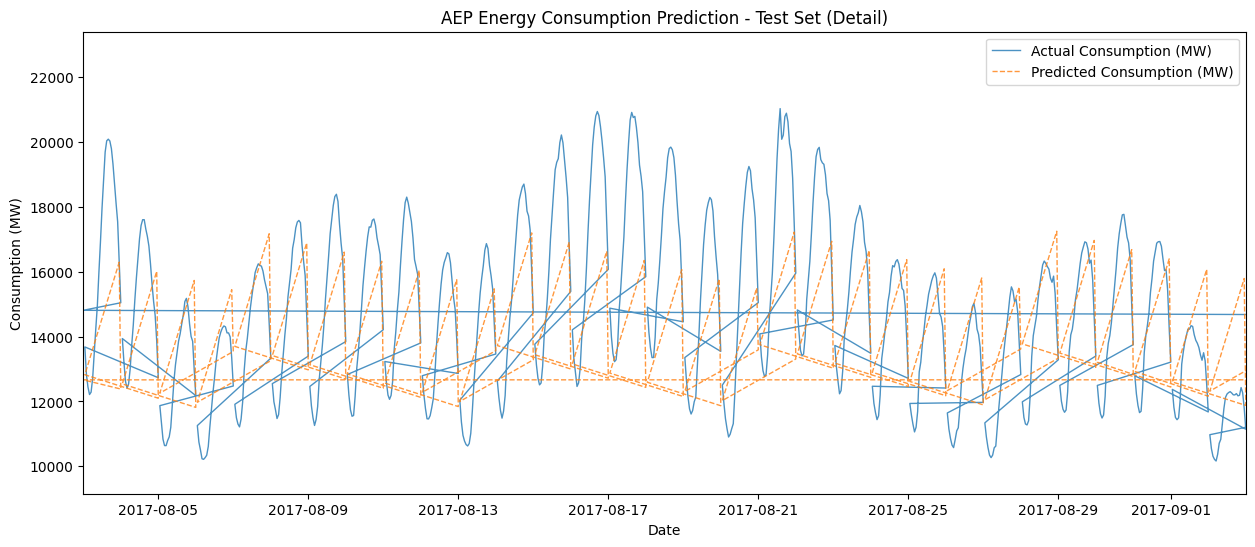


Plotting Actual vs Predicted for the entire test period...


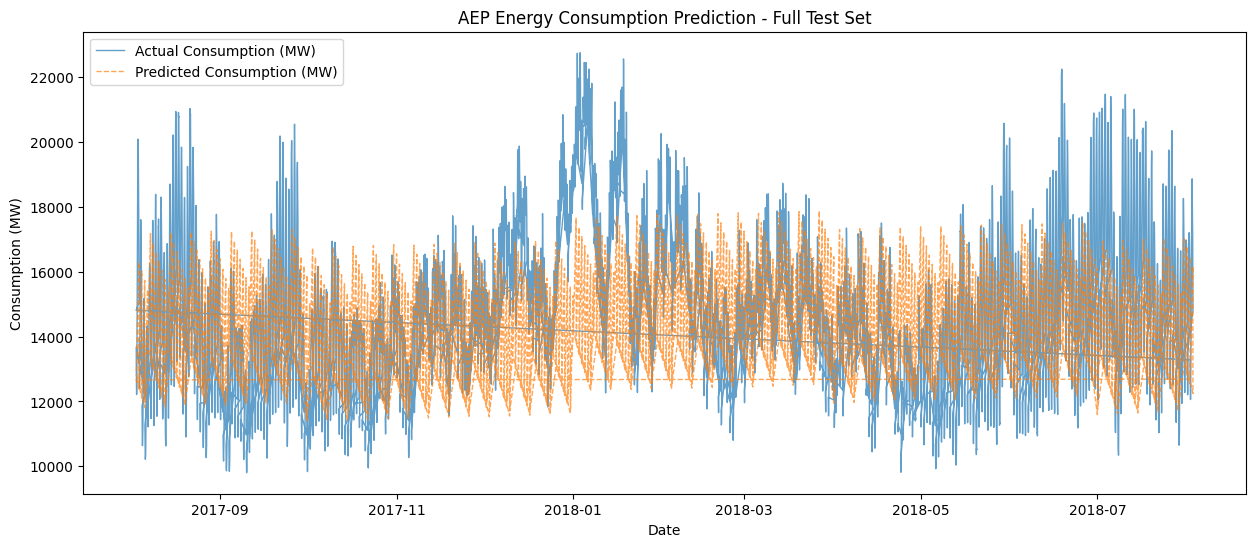

In [18]:
# --- Calculate Mean Absolute Error (MAE) ---
# Assumes y_test and y_pred exist.
print("Calculating model performance metrics...")
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error (MAE) on Test Set: {mae:.2f} MW")

# --- Compare MAE to average load ---
avg_load_test = y_test.mean()
print(f"Average Consumption in Test Set: {avg_load_test:.2f} MW")
mae_percent = (mae / avg_load_test) * 100
print(f"MAE as percentage of Average Consumption: {mae_percent:.2f}%")

# --- Plot Actual vs. Predicted values ---
print("\nPlotting Actual vs. Predicted values for the Test Set (first month)...")
plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Consumption (MW)', linewidth=1.0, alpha=0.8)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Consumption (MW)', linestyle='--', linewidth=1.0, alpha=0.8)
plt.title('AEP Energy Consumption Prediction - Test Set (Detail)')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plot_end_date = results_df.index.min() + pd.DateOffset(months=1)
if plot_end_date > results_df.index.max():
  plot_end_date = results_df.index.max()
plt.xlim([results_df.index.min(), plot_end_date])
plt.show()

print("\nPlotting Actual vs Predicted for the entire test period...")
plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Consumption (MW)', linewidth=1.0, alpha=0.7)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Consumption (MW)', linestyle='--', linewidth=1.0, alpha=0.7)
plt.title('AEP Energy Consumption Prediction - Full Test Set')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.show()

## Exercise 6: Trying a More Sophisticated Model - Random Forest

Linear Regression is a good baseline, but real-world energy consumption patterns can be more complex (non-linear). Let's try a **Random Forest Regressor**.

A Random Forest is an *ensemble* model. It builds multiple decision trees during training and outputs the average of their predictions (for regression tasks). This often leads to better accuracy and more robustness against overfitting compared to a single decision tree.

We'll follow the same steps:
1.  Initialize the `RandomForestRegressor`.
2.  Train it using the same `X_train` and `y_train` data.
3.  Make predictions on `X_test`.
4.  Evaluate its performance using MAE and compare it to our Linear Regression model.


--- Training Random Forest Regressor ---
Random Forest model initialized.
Training with parameters: n_estimators=100, random_state=42, max_depth=20
Fitting Random Forest model to the training data (this might take a moment)...
Random Forest model training complete.

Making predictions with Random Forest model on the test set...
Predictions made by Random Forest model.

Calculating Random Forest model performance metrics...
Random Forest - Mean Absolute Error (MAE) on Test Set: 1338.78 MW
Linear Regression - MAE (for comparison): 1661.51 MW
Random Forest - MAE as percentage of Average Consumption: 8.95%

Sample of Actual vs. Predicted values (Random Forest):
                      Actual  Predicted_RF
Datetime                                  
2017-12-31 01:00:00  17422.0  14486.648650
2017-12-31 02:00:00  17219.0  14481.607956
2017-12-31 03:00:00  17313.0  14469.288682
2017-12-31 04:00:00  17396.0  14479.795210
2017-12-31 05:00:00  17512.0  14498.419723

Plotting Actual vs. Predicted v

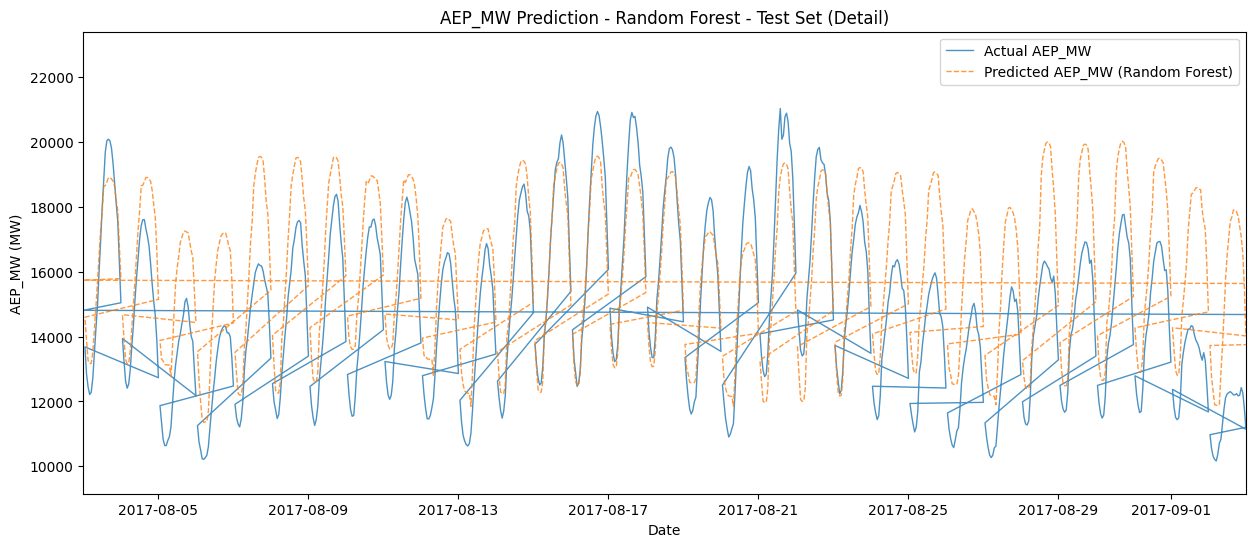


--- Random Forest Feature Importances ---


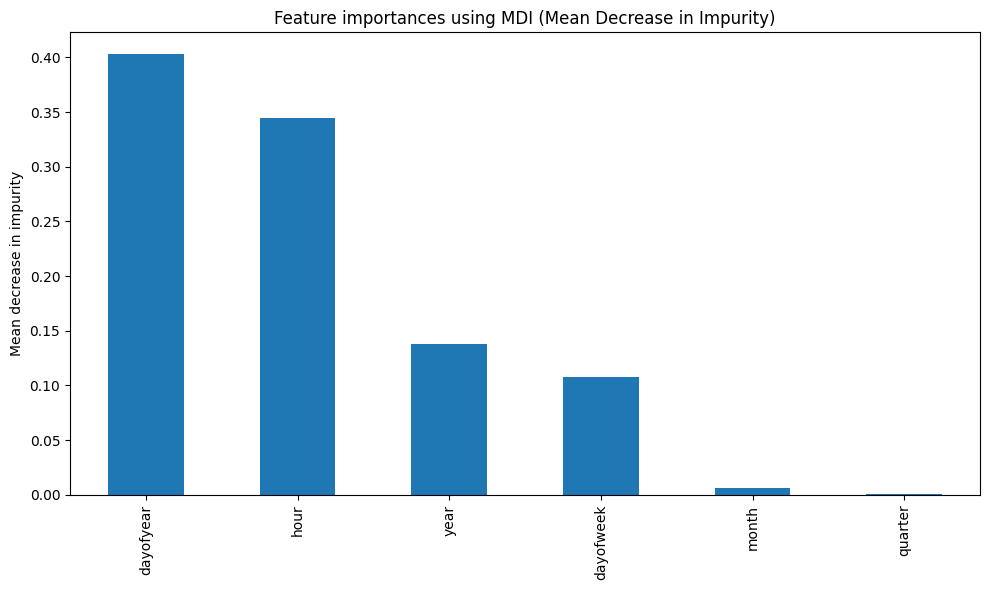

In [19]:
# --- Import RandomForestRegressor ---
from sklearn.ensemble import RandomForestRegressor

# Assumes X_train, y_train, X_test, y_test are available from Code Cell 4.
# Assumes target_column is defined (e.g., 'AEP_MW')

print("\n--- Training Random Forest Regressor ---")

# --- Initialize the Random Forest Regressor ---
# You can experiment with hyperparameters. For a start:
# n_estimators: The number of trees in the forest.
# random_state: Ensures reproducibility.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5, min_samples_leaf=5)
# n_jobs=-1 uses all available processors for training which can speed it up.
# max_depth, min_samples_split, min_samples_leaf are common regularization parameters.

print("Random Forest model initialized.")
print(f"Training with parameters: n_estimators={rf_model.get_params()['n_estimators']}, random_state={rf_model.get_params()['random_state']}, max_depth={rf_model.get_params()['max_depth']}")


# --- Train the Model ---
print("Fitting Random Forest model to the training data (this might take a moment)...")
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

# --- Make Predictions on the Test Set ---
print("\nMaking predictions with Random Forest model on the test set...")
y_pred_rf = rf_model.predict(X_test)
print("Predictions made by Random Forest model.")

# --- Evaluate the Random Forest Model ---
print("\nCalculating Random Forest model performance metrics...")
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest - Mean Absolute Error (MAE) on Test Set: {mae_rf:.2f} MW")

# Compare with Linear Regression MAE (assuming 'mae' variable from Linear Regression evaluation exists)
# This next line will CRASH if 'mae' from the previous model (Linear Regression) isn't in memory.
# To make it robust in a standalone way, you might recalculate/re-assign 'mae' or ensure execution order.
# For "direct execution" as requested, we assume 'mae' exists:
print(f"Linear Regression - MAE (for comparison): {mae:.2f} MW") # Assumes 'mae' holds Linear Regression's MAE

avg_load_test_rf = y_test.mean() # This is the same as avg_load_test from before
mae_percent_rf = (mae_rf / avg_load_test_rf) * 100
print(f"Random Forest - MAE as percentage of Average Consumption: {mae_percent_rf:.2f}%")


# --- Store RF results for comparison ---
results_rf_df = pd.DataFrame({'Actual': y_test, 'Predicted_RF': y_pred_rf}, index=y_test.index)
print("\nSample of Actual vs. Predicted values (Random Forest):")
print(results_rf_df.head())

# --- Plot Actual vs. Predicted values for Random Forest ---
print("\nPlotting Actual vs. Predicted values for Random Forest (Test Set - first month)...")
plt.figure(figsize=(15, 6))
plt.plot(results_rf_df.index, results_rf_df['Actual'], label=f'Actual {target_column}', linewidth=1.0, alpha=0.8)
plt.plot(results_rf_df.index, results_rf_df['Predicted_RF'], label=f'Predicted {target_column} (Random Forest)', linestyle='--', linewidth=1.0, alpha=0.8)
plt.title(f'{target_column} Prediction - Random Forest - Test Set (Detail)')
plt.xlabel('Date')
plt.ylabel(f'{target_column} (MW)')
plt.legend()
# Limit plot to first month of test set for detail
plot_end_date_rf = results_rf_df.index.min() + pd.DateOffset(months=1)
if plot_end_date_rf > results_rf_df.index.max(): # Small conditional for robust plotting
  plot_end_date_rf = results_rf_df.index.max()
plt.xlim([results_rf_df.index.min(), plot_end_date_rf])
plt.show()

# --- Optional: Feature Importances from Random Forest ---
print("\n--- Random Forest Feature Importances ---")
importances_rf = rf_model.feature_importances_
feature_names_rf = X_train.columns # Assumes X_train is a DataFrame with column names
forest_importances = pd.Series(importances_rf, index=feature_names_rf)

fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI (Mean Decrease in Impurity)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()